In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# import libraries to visualize
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# import libraries to process image dataset
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# import libraries to build and evaluate model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"destianiintanc","key":"4cc8fd4b4f19121e1156fe2e6a45ca44"}'}

In [ ]:
# download dataset and unzip it

!kaggle datasets download -d anthonytherrien/dog-vs-cat
!unzip dog-vs-cat.zip

Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat
License(s): CC-BY-SA-4.0
 96% 347M/360M [00:06<00:00, 40.4MB/s]
100% 360M/360M [00:07<00:00, 53.7MB/s]
Archive:  dog-vs-cat.zip
  inflating: animals/cat/00000-4122619873.png  
  inflating: animals/cat/00001-4122619874.png  
  inflating: animals/cat/00002-4122619875.png  
  inflating: animals/cat/00003-4122619876.png  
  inflating: animals/cat/00004-4122619877.png  
  inflating: animals/cat/00005-4122619878.png  
  inflating: animals/cat/00006-4122619879.png  
  inflating: animals/cat/00007-4122619880.png  
  inflating: animals/cat/00008-4122619881.png  
  inflating: animals/cat/00009-4122619882.png  
  inflating: animals/cat/00010-4122619883.png  
  inflating: animals/cat/00011-4122619884.png  
  inflating: animals/cat/00012-4122619885.png  
  inflating: animals/cat/00013-4122619886.png  
  inflating: animals/cat/00014-4122619887.png  
  inflating: animals/cat/00015-4122619888.png  
  inflating: animals/cat/00016-4

# Combine Data Train and Test to the same directory

In [ ]:
cat_dir = "/content/animals/cat"
dog_dir = "/content/animals/dog"

# directory check?
print("Apakah folder kucing ada?", os.path.exists(cat_dir))
print("Apakah folder anjing ada?", os.path.exists(dog_dir))

# folder checking
print("Isi folder kucing:", os.listdir(cat_dir)[:10])  # Tampilkan 10 file pertama
print("Isi folder anjing:", os.listdir(dog_dir)[:10])

Apakah folder kucing ada? True
Apakah folder anjing ada? True
Isi folder kucing: ['00042-200124352.png', '00388-200124698.png', '00304-200124614.png', '00048-200124358.png', '00079-200124389.png', '00340-200124650.png', '00263-200124573.png', '00319-200124629.png', '00115-200124425.png', '00383-200124693.png']
Isi folder anjing: ['00964-3846169126.png', '00817-3846168979.png', '00519-3846168681.png', '00956-3846169118.png', '00993-127787247.png', '00890-3846169052.png', '00702-3846168864.png', '00600-3846168762.png', '00580-3846168742.png', '00709-3846168871.png']


In [ ]:
# Dataset origin path
cat_dir = "/content/animals/cat"
dog_dir = "/content/animals/dog"

# Combined datase path
combined_dir = "/content/drive/MyDrive/dicoding/dataset"

# make folder
os.makedirs(combined_dir, exist_ok=True)

# function to copy file
def copy_files(source_dir, target_dir, label):
    total_files = 0
    target_label_dir = os.path.join(target_dir, label)

    os.makedirs(target_label_dir, exist_ok=True)

    for file_name in os.listdir(source_dir):
        source_file = os.path.join(source_dir, file_name)
        target_file = os.path.join(target_label_dir, file_name)

        # copy only file
        if os.path.isfile(source_file):
            shutil.copy2(source_file, target_file)
            total_files += 1

    return total_files

# copy files
cat_files = copy_files(cat_dir, combined_dir, "cat")
dog_files = copy_files(dog_dir, combined_dir, "dog")

print(f"Total Cat Dataset: {cat_files}")
print(f"Total Dog Dataset: {dog_files}")
print("Copy Process Success!")

Total Cat Dataset: 500
Total Dog Dataset: 500
Copy Process Success!


# Plot Sample for All Classes

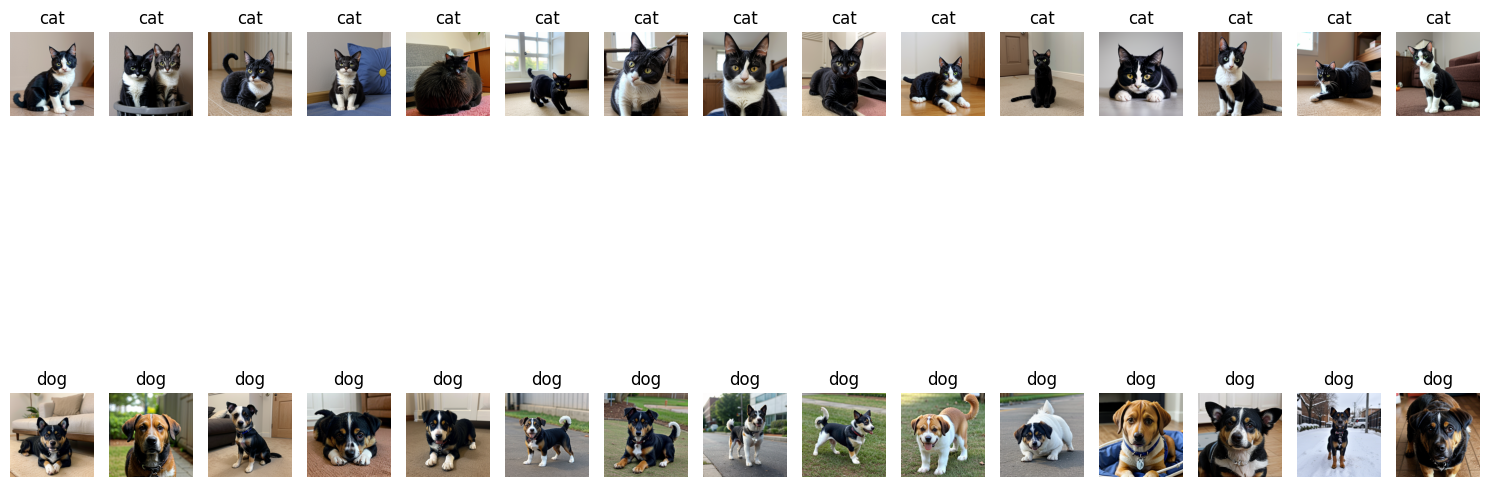

In [ ]:
# path dataset
dataset_path = "/content/drive/MyDrive/dicoding/dataset"

# classes
classes = os.listdir(dataset_path)

# show image per class
num_images = 15

# Plotting
fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 5 * len(classes)))

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    # random image
    selected_images = np.random.choice(image_files, num_images, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(class_path, image_name)
        img = Image.open(img_path)

        # show image
        axes[i, j].imshow(img)
        axes[i, j].set_title(class_name)
        axes[i, j].axis("off")

# show all images
plt.tight_layout()
plt.show()

# Class Distribution

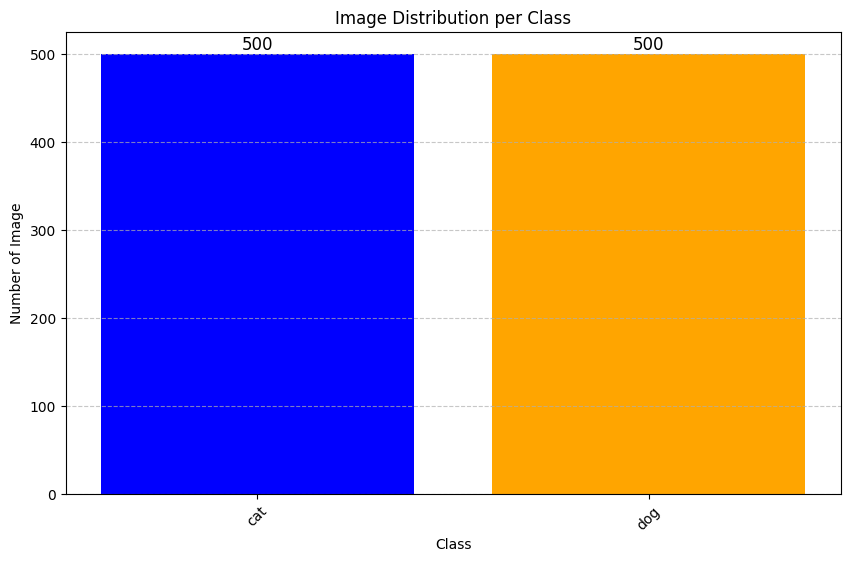

In [ ]:
# combined dataset path
dataset_path = "/content/drive/MyDrive/dicoding/dataset"

# get class
classes = os.listdir(dataset_path)

# count image per class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}

# image distribution plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Number of Image")
plt.title("Image Distribution per Class")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# show total images per class
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 5, str(count), ha="center", fontsize=12)

# show plot
plt.show()

# Data Augmentation

In [ ]:
# Path dataset
dataset_path = "/content/drive/MyDrive/dicoding/dataset"

# Augmentasi with ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,        # pixel normalization (0-1)
    rotation_range=30,          # random rotation
    width_shift_range=0.2,      # horizontal
    height_shift_range=0.2,     # vertikal
    shear_range=0.2,            # distortion
    zoom_range=0.2,             # random zoom
    horizontal_flip=True,       # Flips the image horizontally
    fill_mode="nearest"         # Fill in the blank area with the closest method
)

# Load dataset with augmentation
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),  # Resize image to be 150x150
    batch_size=32,
    class_mode="categorical"
)

Found 1000 images belonging to 2 classes.


In [ ]:
# origin path
dataset_path = "/content/drive/MyDrive/dicoding/dataset"
augmented_path = "/content/drive/MyDrive/dicoding/augmented_dataset"

os.makedirs(augmented_path, exist_ok=True)

# determine augmentation per image
augmentation_factor = 4

# Augmentasi using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,     # 30 degree rotation
    width_shift_range=0.2, # horizontal
    height_shift_range=0.2,# vertikal
    shear_range=0.2,       # for distortion
    zoom_range=0.2,        # zoom in/out
    horizontal_flip=True,  # flip horizontal
    fill_mode='nearest'    # Fill in the blank area with the closest method
)

# iteration for each class
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    augmented_class_path = os.path.join(augmented_path, class_name)

    # folder for each class
    os.makedirs(augmented_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        print(f"🔄 Augmentasi untuk kelas: {class_name}")

        # get all files
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path)  # Load image
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

            # make and save image in the new path
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_class_path,
                                      save_prefix=f"aug_{i}_{img_file.split('.')[0]}", save_format='png'):
                i += 1
                if i >= augmentation_factor:
                    break

print("SAVED !")

🔄 Augmentasi untuk kelas: cat
🔄 Augmentasi untuk kelas: dog
SAVED !


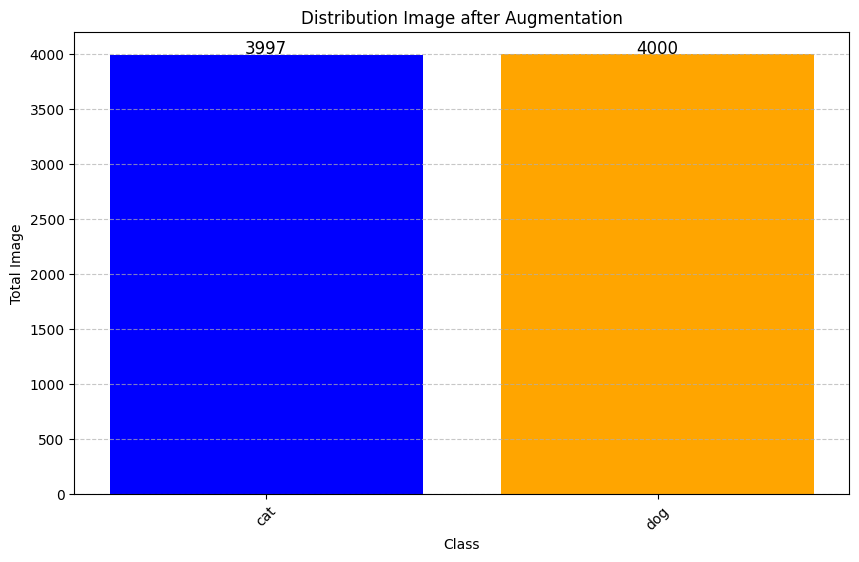

In [ ]:
# new distribution image
# count image each class after augmentation
class_counts = {class_name: len(os.listdir(os.path.join(augmented_path, class_name)))
                for class_name in os.listdir(augmented_path)}

# distribution plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Total Image")
plt.title("Distribution Image after Augmentation")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# add label
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 5, str(count), ha="center", fontsize=12)

# show plot
plt.show()

# Data Splitting

In [ ]:
# new path for current augmentation
mypath = "/content/drive/MyDrive/dicoding/augmented_dataset/"

# List to save the data
file_name = []
labels = []
full_path = []

# Looping to get path, file name and class label
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# make dataframe
df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# check total data each class
print(df.groupby(['labels']).size())

labels
cat    3997
dog    4000
dtype: int64


In [ ]:
# splitting dataset
# Variabel X = image path, y = image label
X = df["path"]
y = df["labels"]

# Split dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split test to be validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# confirmation total data split
print(f"Total Data: {len(df)}")
print(f"Train Data: {len(X_train)}")
print(f"Validation Data: {len(X_val)}")
print(f"Test Data: {len(X_test)}")

Total Data: 7997
Train Data: 5597
Validation Data: 1200
Test Data: 1200


In [ ]:
# path splitting dataset
split_path = "/content/drive/MyDrive/dicoding/split_dataset"
train_dir = os.path.join(split_path, "train")
val_dir = os.path.join(split_path, "validation")
test_dir = os.path.join(split_path, "test")

# directory for train, validation, and test
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# copy file to each directory function
def copy_files(X, y, target_dir):
    for path, label in zip(X, y):
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(path, os.path.join(label_dir, os.path.basename(path)))

# copy file to right direction
copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, val_dir)
copy_files(X_test, y_test, test_dir)

print("Done !")

Done !


In [ ]:
# Path dataset awal
datasource_path = "/content/drive/MyDrive/dicoding/augmented_dataset/"

# dataset akhir
dataset_path = "/content/drive/MyDrive/dicoding/Dataset-Final/"

os.makedirs(dataset_path, exist_ok=True)

# combine dataset into 1 dataframe
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'validation'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})


df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# copy to new directory
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row["path"]  # Path image origin

    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row["labels"], row["file_name"])

    # directory destination
    target_dir = os.path.join(dataset_path, row["set"], row["labels"])
    os.makedirs(target_dir, exist_ok=True)  # make a new folder

    # determine directoy destination
    destination_file_name = os.path.basename(file_path)  # get file name
    file_dest = os.path.join(target_dir, destination_file_name)

    # copy file
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

print("DONE ✅")

100%|██████████| 7997/7997 [02:44<00:00, 48.73it/s]

DONE ✅


# Image Data Generator

In [ ]:
# path dataset
TRAIN_DIR = "/content/drive/MyDrive/dicoding/Dataset-Final/train/"
TEST_DIR = "/content/drive/MyDrive/dicoding/Dataset-Final/test/"

# path for each class
train_cat = os.path.join(TRAIN_DIR, "cat")
train_dog = os.path.join(TRAIN_DIR, "dog")
test_cat = os.path.join(TEST_DIR, "cat")
test_dog = os.path.join(TEST_DIR, "dog")

# image check per class
print("Total number of cat images in training set: ", len(os.listdir(train_cat)))
print("Total number of dog images in training set: ", len(os.listdir(train_dog)))
print("Total number of cat images in test set: ", len(os.listdir(test_cat)))
print("Total number of dog images in test set: ", len(os.listdir(test_dog)))

Total number of cat images in training set:  3220
Total number of dog images in training set:  3217
Total number of cat images in test set:  860
Total number of dog images in test set:  849


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training augmentation data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization pixel to range [0,1]
    rotation_range=20,  # image rotation up to 20 degree
    width_shift_range=0.2,  # horizontal
    height_shift_range=0.2,  # vertical
    shear_range=0.2,  # shear
    zoom_range=0.2,  # zoom
    horizontal_flip=True,  # flip horizontal
    validation_split=0.2  # split dataset
)

# Data generator to validation and test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# load dataset with generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),  # Resize image 150x150
    batch_size=32,  # Batch size 32
    class_mode='binary',  # 2 class
    subset='training'  # get training data
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # get validation data
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# total sample checking
print("Total training images:", train_generator.samples)
print("Total validation images:", validation_generator.samples)
print("Total testing images:", test_generator.samples)

Found 5150 images belonging to 2 classes.
Found 1287 images belonging to 2 classes.
Found 1709 images belonging to 2 classes.
Total training images: 5150
Total validation images: 1287
Total testing images: 1709


# Model 1 - CNN Architecture Using 64 Neurons in Conv Layer

In [ ]:
# clear previous session
tf.keras.backend.clear_session()

model = Sequential()

# 1st Convolutional Layer + Batch Normalization + Pooling Layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))  # 3 channels (RGB)
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 2nd Convolutional Layer + Batch Normalization + Pooling Layer
model.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 3rd Convolutional Layer + Batch Normalization + Pooling Layer
model.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Flatten Layer to change the conv result to be in 1D vector
model.add(Flatten())

# Fully Connected Layer (Dense Layer)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to avoid overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer for binary classification (cat vs dog)
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# architecture model sum
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 64)          │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,931,585 (11.18 MB)

 Trainable params: 2,931,201 (11.18 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Train model
# Callback to stop the training process if val loss doesnt improve
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20,
    batch_size = 32,
    callbacks = [early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1288s 8s/step - accuracy: 0.6076 - loss: 2.3582 - val_accuracy: 0.5890 - val_loss: 0.7426
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1198s 7s/step - accuracy: 0.7241 - loss: 0.8554 - val_accuracy: 0.7335 - val_loss: 0.6530
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1213s 7s/step - accuracy: 0.8516 - loss: 0.4306 - val_accuracy: 0.8858 - val_loss: 0.3598
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1187s 7s/step - accuracy: 0.9173 - loss: 0.2878 - val_accuracy: 0.9518 - val_loss: 0.1285
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1185s 7s/step - accuracy: 0.9406 - loss: 0.2090 - val_accuracy: 0.7653 - val_loss: 1.5813
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1203s 7s/step - accuracy: 0.9498 - loss: 0.1838 - val_accuracy: 0.5936 - val_loss: 1.7368
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1187s 7s/step - accuracy: 0.9594 - loss: 0.1304 - val_accuracy: 0.8819 - val_loss: 0.6117
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1179s 7s/step - accuracy: 0.9702 - loss: 0.1009 - 

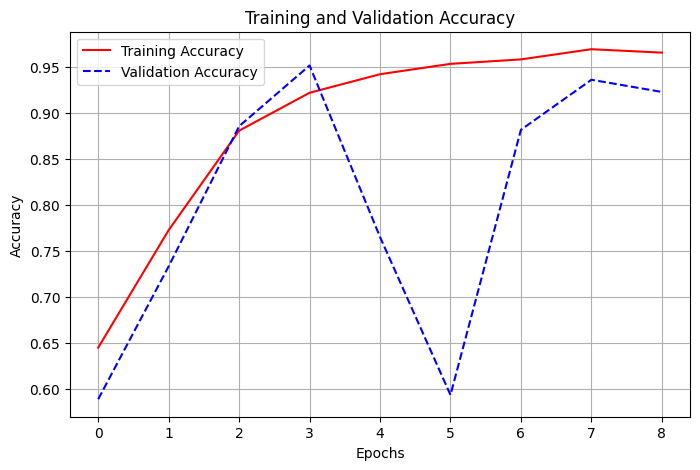

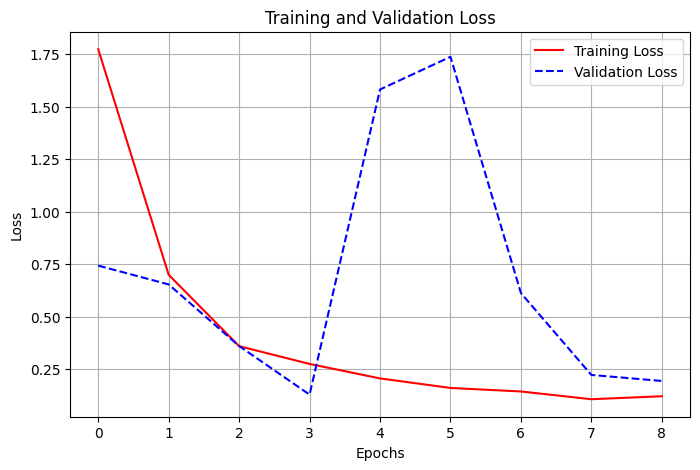

In [ ]:
# history training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # total epoch

# Plot Training & Validation Accuracy
plt.figure(figsize = (8, 5))
plt.plot(epochs, acc, 'r-', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize = (8, 5))
plt.plot(epochs, loss, 'r-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b--', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step


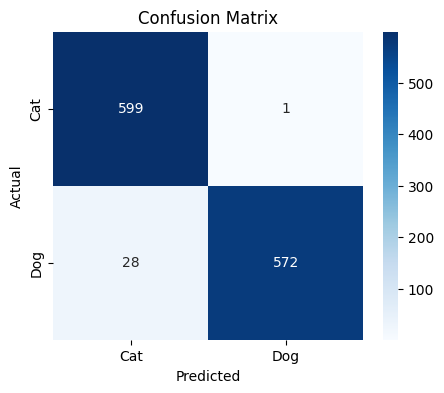

Classification Report:
               precision    recall  f1-score   support

         Cat       0.96      1.00      0.98       600
         Dog       1.00      0.95      0.98       600

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns # Make sure seaborn is imported

# Function to load and preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))  # Load image with target size
    img = img_to_array(img)  # Convert to array
    img = img / 255.0  # Normalize pixel values
    return img

# Preprocess images in X_test
X_test_processed = np.array([preprocess_image(image_path) for image_path in X_test])

# Make prediction using the processed data
y_pred_prob = model.predict(X_test_processed) # Get probabilities
y_pred = np.round(y_pred_prob)  # Round to 0 or 1

# Convert y_pred to string labels (if needed)
y_pred_labels = ['cat' if pred < 0.5 else 'dog' for pred in y_pred_prob.flatten()]

# confusion matrix
cm = confusion_matrix(y_test, y_pred_labels) # Use string labels for y_pred_labels

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels, target_names=['Cat', 'Dog'])) # Use y_pred_labels for report

# **Save Model**

In [ ]:
saved_model_path = "/content/drive/MyDrive/dicoding/submission/saved_model"

# Save the model
tf.saved_model.save(model, saved_model_path)

print(f"Model saved in SavedModel format at : {saved_model_path}")

Model saved in SavedModel format at : /content/drive/MyDrive/dicoding/submission/saved_model


In [ ]:
!pip install tensorflowjs

# Path tujuan untuk model TFJS
tfjs_model_path = "/content/drive/MyDrive/dicoding/submission/tfjs_model"

# Pastikan folder tujuan ada
os.makedirs(tfjs_model_path, exist_ok=True)

# Konversi model ke format TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model {saved_model_path} {tfjs_model_path}

print(f"Model successfully convert to TensorFlow.js format at: {tfjs_model_path}")

2025-03-11 07:08:11.807046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741676891.831746   87597 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741676891.838990   87597 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-11 07:08:17.240495: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1741676897.718473   87597 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
# Load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved in TFLite format at: {tflite_model_path}")

Model saved in TFLite format at: /content/drive/MyDrive/dicoding/submission/tflite/model.tflite


# *Testing*

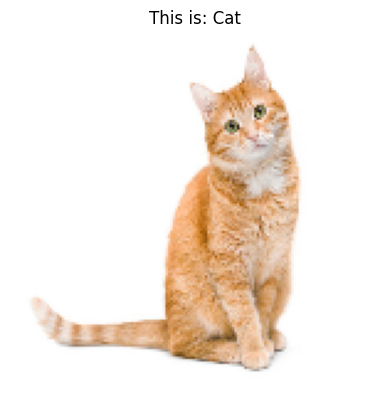

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# test image path
image_path = "/content/drive/MyDrive/dicoding/test.jpg"

# Load the SavedModel
model = tf.saved_model.load("/content/drive/MyDrive/dicoding/submission/saved_model")

# Access the 'serving_default' signature (this is the common signature for prediction)
infer = model.signatures['serving_default']

# load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
img = cv2.resize(img, (150, 150))  # Sesuaikan ukuran gambar dengan input model
img = img / 255.0  # Normalisasi pixel antara 0-1
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension

# Make prediction using the signature
# Convert the image to a TensorFlow tensor
img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

# Pass the image to the model for prediction
predictions = infer(img_tensor)

# Access the prediction output (usually named 'output_1' or similar)
# The key was incorrect, changed to 'output_0' based on the Global variables
prediction = predictions['output_0'].numpy()

# show image and result
plt.imshow(img[0])
plt.axis("off")
plt.title(f"This is: {'Cat' if prediction[0][0] < 0.5 else 'Dog'}")
plt.show()